## I. Importing packages

In [3]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, shutil
import random
import cv2

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

## II. Data preprocessing (numerical data)

    1. Importing data

In [4]:
df = pd.read_csv('numerical_dataset.csv', encoding= 'unicode_escape')


print(df.shape)

df.head(5)

(22371, 80)


,Area_No,School_No,Exam_No,Area_ID,Exam_ID,Sido_No,Region_No,Gungu_No,School,Age,...,X14_4,X14_5,X14_6,X14_7,X14_8,X14_9,X15,x15_1,X16,presence_of_caries
0,1102,160,1,9,1654,10,1,34.0,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0
1,2105,442,3,50,1642,14,1,77.0,3,2,...,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,3.0,0
2,2106,459,2,26,10988,14,1,76.0,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,1
3,2201,562,3,38,4921,12,1,58.0,3,2,...,0.0,1.0,0.0,0.0,0.0,0.0,5.0,3.0,3.0,0
4,2106,469,3,69,1727,14,1,76.0,3,2,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,6.0,0


In [5]:
df_copy = df.copy()
df_copy.shape

(22371, 80)

    2. Data preprocessing

        2.1 Data cleaning

In [6]:
#Replace empty cell by the most occuring values in each cell
for column in df_copy.columns:
    #print(column)
    df_copy[column].fillna(df_copy[column].mode()[0],inplace=True)

In [7]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22371 entries, 0 to 22370
Data columns (total 80 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Area_No             22371 non-null  int64  
 1   School_No           22371 non-null  int64  
 2   Exam_No             22371 non-null  int64  
 3   Area_ID             22371 non-null  int64  
 4   Exam_ID             22371 non-null  int64  
 5   Sido_No             22371 non-null  int64  
 6   Region_No           22371 non-null  int64  
 7   Gungu_No            22371 non-null  float64
 8   School              22371 non-null  int64  
 9   Age                 22371 non-null  int64  
 10  Gender              22371 non-null  int64  
 11  Strata              22371 non-null  int64  
 12  Weight              22371 non-null  int64  
 13  Calculus            22371 non-null  float64
 14  Bleeding            22371 non-null  float64
 15  Fluorosis           22371 non-null  int64  
 16  Trau

In [8]:
# Verify if we do not have any empty cell
null_counts = df_copy.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

array([[<AxesSubplot:title={'center':'presence_of_caries'}>]],
      dtype=object)

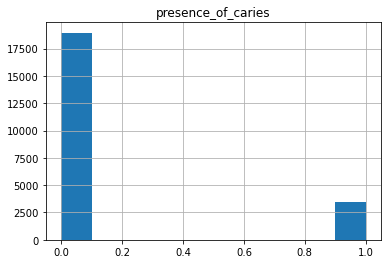

In [9]:
# Check data distribution with respect to the label before oversampling
df_copy.hist(column="presence_of_caries") 

        2.2 Feature selection

            . Using Correlation

<AxesSubplot:>

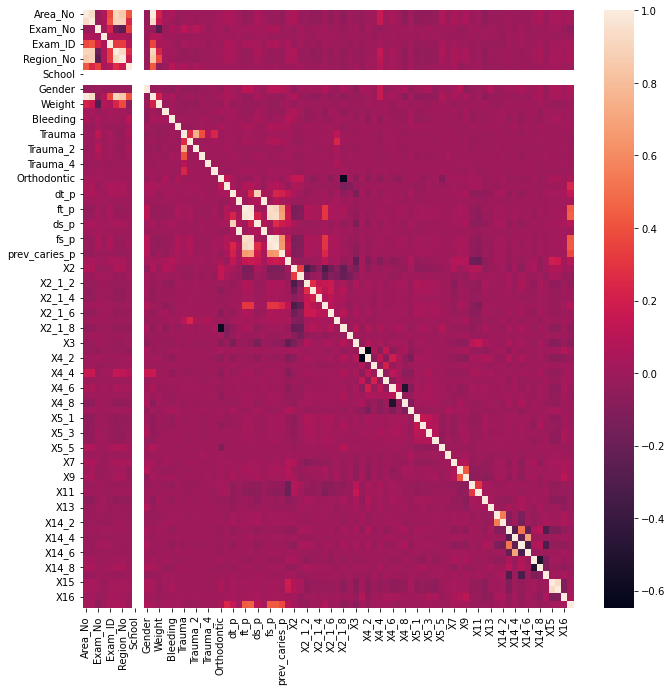

In [10]:
import seaborn as sns
#Using Pearson Correlation
cor = df_copy.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(cor)

In [11]:
# create a function that will select the highly correlated features
# it will remove the first feature that is correlated with any other feature

def remove_correled_feature(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [12]:
corr_features = remove_correled_feature(df_copy, 0.8)
len(set(corr_features))

10

In [13]:
for column in corr_features:
    if column != 'presence_of_caries':
        df_copy.drop(column,axis=1,inplace=True)
df_copy.drop(["School","Age","Gungu_No"],axis=1,inplace=True)

<AxesSubplot:>

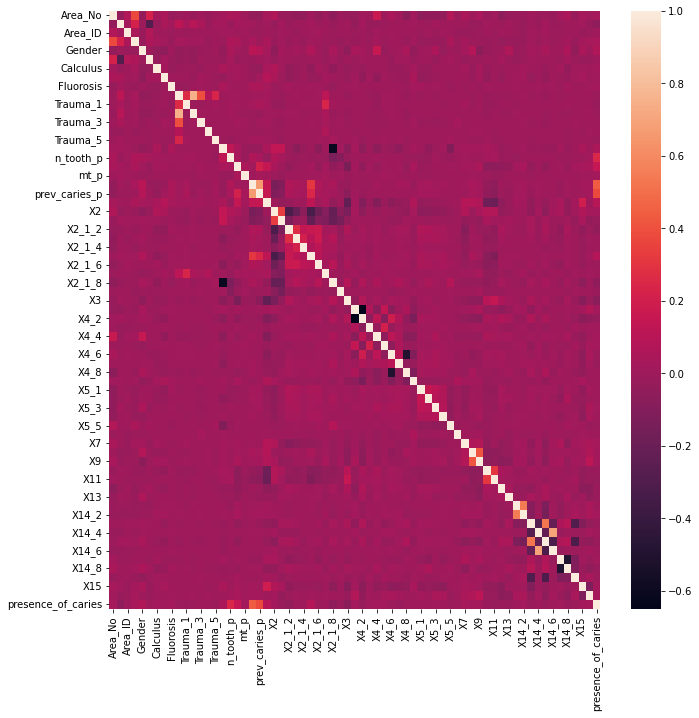

In [14]:
#Correlation matrix after removing variable with high correlation

corrmat = df_copy.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

        . With Information gain-mutual information

In [15]:
from sklearn.feature_selection import mutual_info_classif

X = df_copy.drop("presence_of_caries",axis=1)
y = df_copy["presence_of_caries"]

<AxesSubplot:>

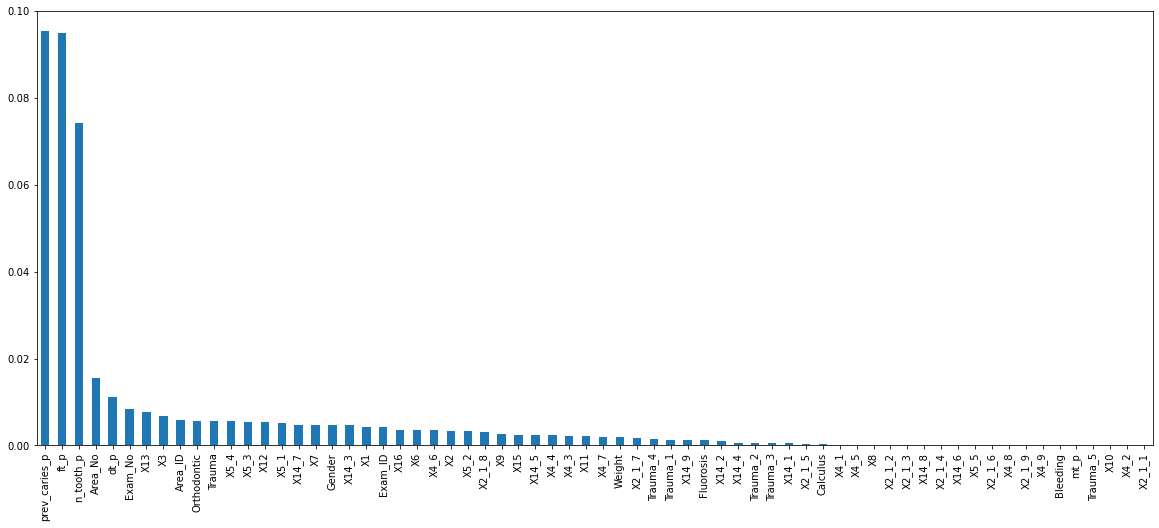

In [16]:
# Before the selection of the most importante features
# determine the mutual information

mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [17]:
# Select the first 28 features based on the Mutual information gain

mutual_info_t = mutual_info.sort_values(ascending=False)

list_important_index = mutual_info_t.index[0:28]

for index in mutual_info_t.index:
    if index not in list_important_index:
        X.drop(index,axis=1,inplace=True)

<AxesSubplot:>

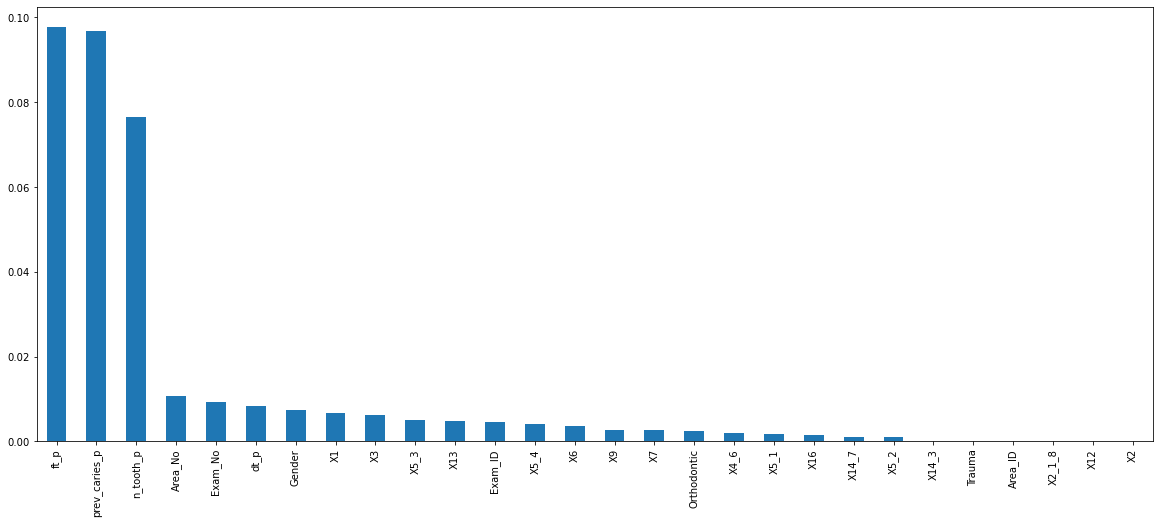

In [18]:
# After the selection of the most importante features

mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

        2.3 Oversample the data

In [19]:
over = SMOTE(sampling_strategy=0.7)

X_df, Y = over.fit_resample(X, y)

array([[<AxesSubplot:title={'center':'presence_of_caries'}>]],
      dtype=object)

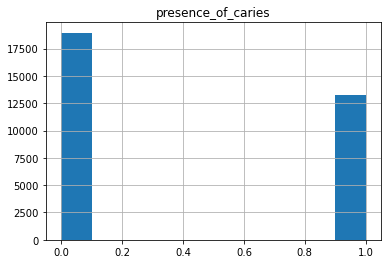

In [20]:
# Check data distribution with respect to the label after oversampling

df_concat = pd.concat([X_df, Y], axis=1)
df_concat.hist(column="presence_of_caries") 

        2.4 Data Scaling

In [25]:
from sklearn.preprocessing import StandardScaler

X = df_concat.drop("presence_of_caries",axis=1)
y = df_concat["presence_of_caries"]
scaler = StandardScaler().fit(X)
# Scale the train set
X = scaler.transform(X)

In [26]:
#numerical data ready for the training
X_num = X
y_num = y

## III. Data preprocessing (image data)

    1. Load the dataset

In [27]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("totalimg/")))
random.shuffle(imagePaths)

for img in imagePaths:
    image = cv2.imread("totalimg/"+img)
    #print(image)
    image = cv2.resize(image, (32,32))
    image = np.array(image)
    data.append(image)
    l = label = img
    labels.append(l)

    2. Image scaling and labelizing

In [28]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)

X_img = data
y_img = labels

## IV. Build our Multi-input, mixed data network

#### Define the CNN branch

In [29]:
def create_cnn():
    
    conv_base = DenseNet201(include_top=False, weights='imagenet', input_shape=(32,32,3))
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.GlobalAveragePooling2D())
    
    return model

#### Define the ANN branch

In [31]:
from keras.utils.vis_utils import plot_model

def create_ann(input1_shape):
    model = Sequential()

    model.add(Dense(78, input_shape=(input1_shape,), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(53, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(38, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(17, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu'))
    model.add(Flatten())
    return model

### Concatenate the models

In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X_num, y_num, test_size=.20,random_state = 42)

X_train_img, X_test_img = train_test_split(X_img,  test_size=.20,random_state = 42)

input1_shape = X_train_num.shape[1]

# create the MLP and CNN models
ann = create_ann(input1_shape)
cnn = create_cnn()

merge = concatenate([ann.output,cnn.output])

hidden1 = Dense(4, activation='relu')(merge)
output = Dense(1, activation="sigmoid")(hidden1)

model = Model(inputs = [ann.input, cnn.input], outputs = output)

model.compile(metrics=["Accuracy"],loss="binary_crossentropy", optimizer='Adam')


history = model.fit(
                    x=[X_train_num, X_train_img], y=y_train_num,
                    epochs=100,
                    batch_size=580,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

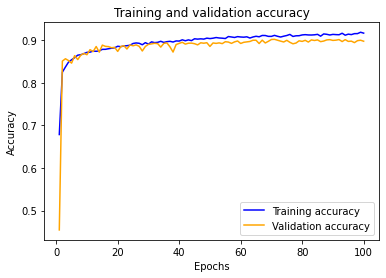

In [36]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'blue', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

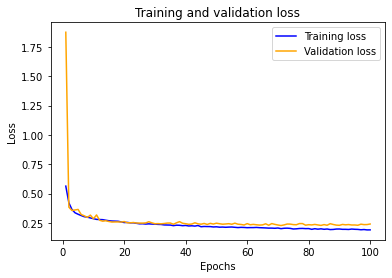

In [37]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## V. Evaluate our model

    1. Classification repport of the model after testing using test set

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# see how these are numbers between 0 and 1? 
#model.predict([X_test_num,X_test_img]) # prob of successes (survival)
#np.round(model1.predict([X_test_num,X_test_img]),0) # 1 and 0 (survival or not)
 # 1 and 0 (survival or X_test_fs)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict([X_test_num,X_test_img]),0)

# confusion matrix
print(confusion_matrix(y_test_num, preds)) # order matters! (actual, predicted)

## array([[490,  59],   ([[TN, FP],
##       [105, 235]])     [Fn, TP]])

print(classification_report(y_test_num, preds))

[[3338  485]
 [ 191 2431]]
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      3823
           1       0.83      0.93      0.88      2622

    accuracy                           0.90      6445
   macro avg       0.89      0.90      0.89      6445
weighted avg       0.90      0.90      0.90      6445



In [ ]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

#Calculate fpr, trp, and threshold
fpr, tpr, thresholds = roc_curve(y_test_num,preds)

    2. Evaluation of the model using ROC AUC curve

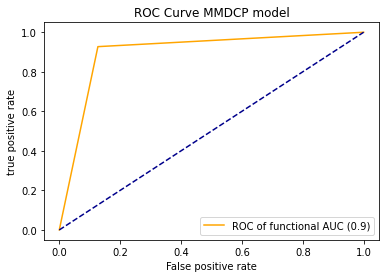

In [56]:
#create a function for plotting ROC curves
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


def plot_roc_curve(fpr,tpr):
    """
    Plots a ROC curve given the false positive (fpr)
    and true positive rate (tpr) of a model.
    """
    roc_score = round(roc_auc_score(y_test_num,preds),2)

    #plot roc curve
    plt.plot(fpr,tpr,color="orange",label="ROC of functional AUC ("+str(roc_score)+")")
    #plot line with no predictive power (baseline)
    plt.plot([0,1],[0,1],color="darkblue",linestyle="--",label="")
    #customize the plot
    plt.xlabel("False positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC Curve MMDCP model")
    plt.legend()
    plt.show()
    
plot_roc_curve(fpr,tpr)

    3. Confusion matrix of the proposed model on the test set

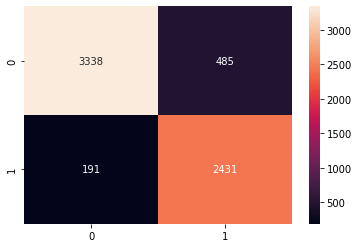

In [59]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_num, preds)
f = sns.heatmap(cm, annot=True, fmt='d')
